# This file demonstrates my step-by-step approach to finding the lane lines

Note that the main script is in the root directory of this repository called *main.ipynb*

In [1]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt

## First I compute the camera transformation and the distance matrices

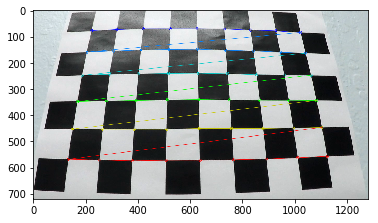

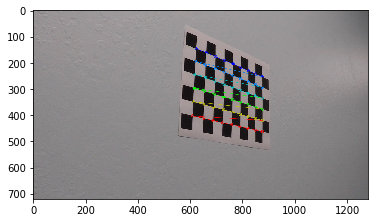

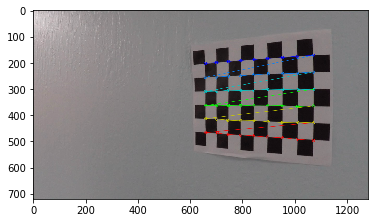

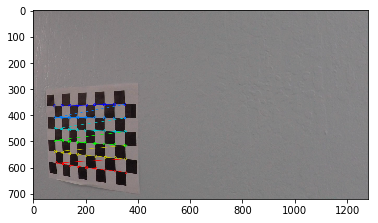

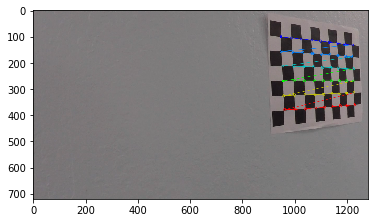

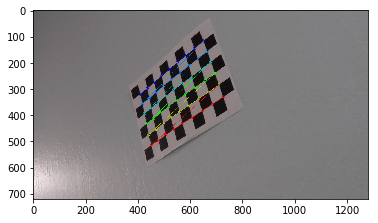

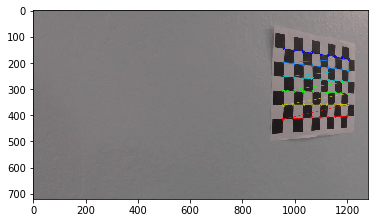

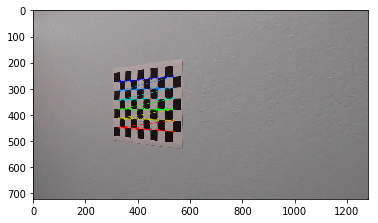

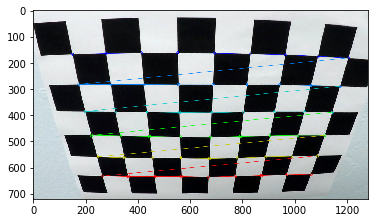

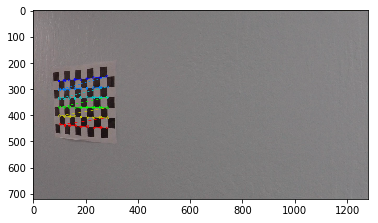

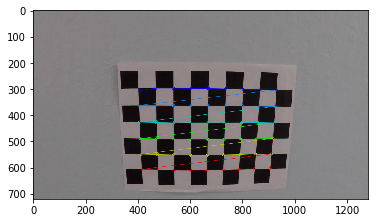

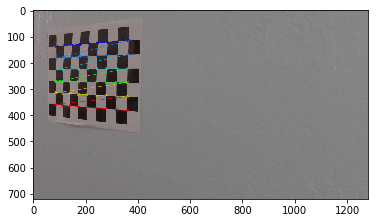

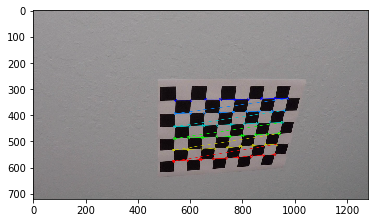

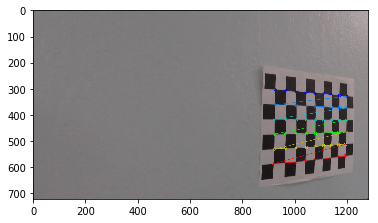

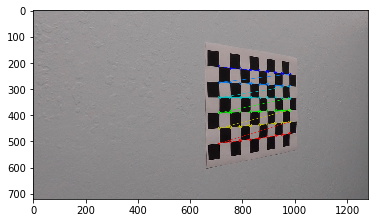

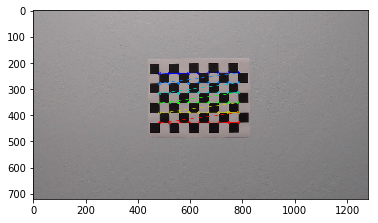

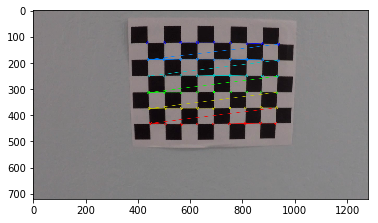

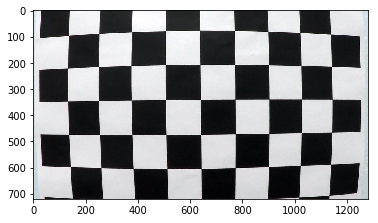

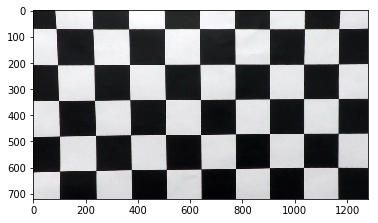

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)


# Compute camera calibration matrices using the calibration images.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# A random image to test the calibration result
test_img = cv2.imread(images[-8])
plt.figure()
plt.imshow(test_img)

# Undistort the above image
# gray_test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
dst = cv2.undistort(test_img, mtx, dist, None, mtx)

# Show undistorted image. It seems like the calibration works fine.

plt.figure()
plt.imshow(dst)

## Check the calibration matrices

A random input to calibrate:

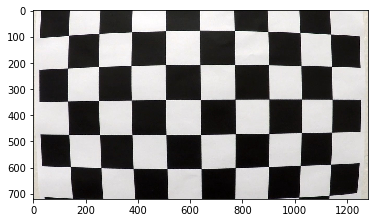

In [24]:
sample = plt.imread(images[12])
plt.imshow(sample)

Undistorted version:

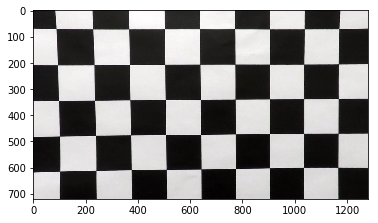

In [25]:
undst_ln_img = cv2.undistort(sample, mtx, dist, None, mtx)
plt.imshow(undst_ln_img)

## Plot a test image to show the pipeline

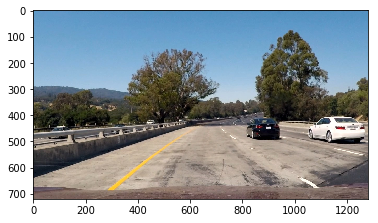

In [3]:
## Line Detection On Test Images
ln_test_imgs = glob.glob('../test_images/*.jpg')
ln_test_imgs

# Plot a test image
ln_img = plt.imread(ln_test_imgs[0])
plt.imshow(ln_img)

## Undistort the image using the calibrated camera matrices found above

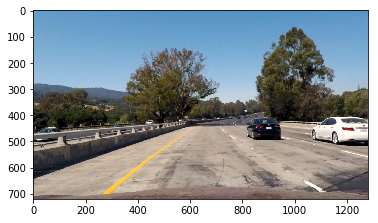

In [4]:
# Undistort the image
undst_ln_img = cv2.undistort(ln_img, mtx, dist, None, mtx)
plt.imshow(undst_ln_img)

## Extract the s channel information using the hls color space

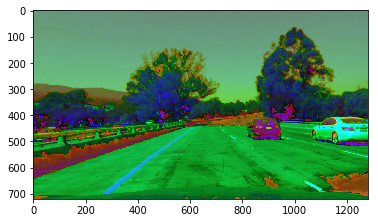

In [5]:
hls = cv2.cvtColor(undst_ln_img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

plt.imshow(hls)


## Compute the absolute sobel filter output and emphasize the found pixels by multiplying them with 255 to plot the result

We will roughly see the edges in the image, that's the purpose of using the sobel filter

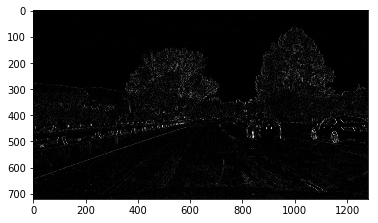

In [6]:
gray = cv2.cvtColor(undst_ln_img, cv2.COLOR_RGB2GRAY)

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

plt.imshow(scaled_sobel, cmap='gray')

## Threshold the gradients calculated using sobel filter to get the edges clearer 

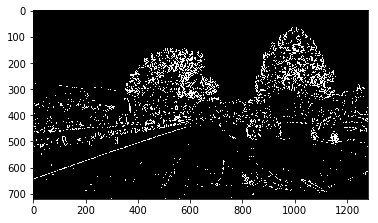

In [7]:
# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

plt.imshow(sxbinary, cmap='gray')

## Threshold the color in pursuit of obtaining more line information then anything else in the image concerning the color space

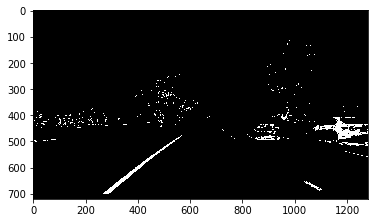

In [8]:
# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

#%%

plt.imshow(s_binary, cmap='gray')

## Visualize the contribution of both thresholding performed above

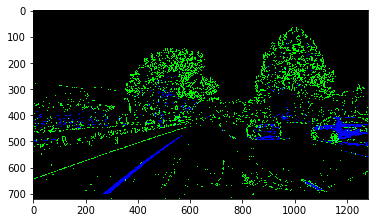

In [9]:
# Contribution of both gradient and color information is seen below. Blue is the color information whereas the green is the gradient contribution.
plt.imshow((np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255), cmap='gray')

## Combine both thresholded images into one image

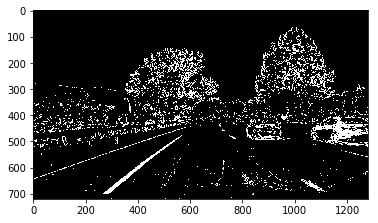

In [10]:
# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

plt.imshow(combined_binary, cmap='gray')

## Perspective transform to get to BEV for radius of curvature and distance to center computations on the next step

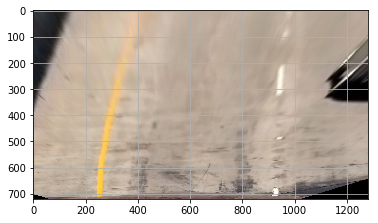

In [11]:
## Get to BEV
height = ln_img.shape[0]
width = ln_img.shape[1]
# Vertices coordinates in the source image
s1 = [575, 460]
s2 = [710, 460]
s3 = [315, height]
s4 = [1120, height]
src = np.float32([s1, s2, s3, s4])
# Vertices coordinates in the destination image
d1 = [300, 0]
d2 = [900, 0]
d3 = [300, height]
d4 = [900, height]
dst = np.float32([d1, d2, d3, d4])

#%%

# Given src and dst points we calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image
warped = cv2.warpPerspective(undst_ln_img, M, (width, height))
# We also calculate the oposite transform
unwrap_m = cv2.getPerspectiveTransform(dst, src)

#%%

plt.figure()
plt.grid()
plt.imshow(warped)
plt.show()

## Combine all line detection pipeline as a method and visualize the resulting image

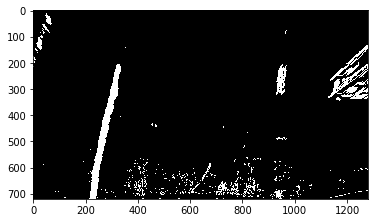

In [12]:
def detection_pipeline(img, mtx, dist):
    
    undst_ln_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    hls = cv2.cvtColor(undst_ln_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(undst_ln_img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

#%%

out = detection_pipeline(warped, mtx=mtx, dist=dist)
plt.imshow(out, cmap='gray')

## Compute the histogram to find the peak values which we know denoting the right and left lane lines

This sample test image is indeed a challanging one since the right line is dashed as pretty widely gapped. See how the left line outstands in the histogram plot below.

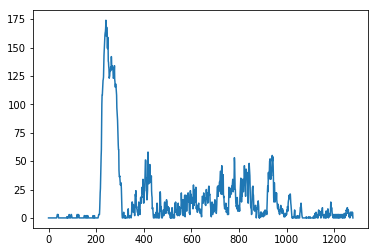

In [13]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

histogram = hist(out)
# Visualize the resulting histogram
plt.plot(histogram)

## Find lane pixels and fit polynomial onto them to get the line equations

Sliding windows are used to get the line pixels for a more stable line fitting

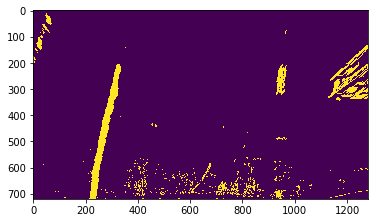

In [14]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

binary_warped = detection_pipeline(warped, mtx, dist)

plt.imshow(binary_warped)

Line pixels and the sliding windows are visualized.

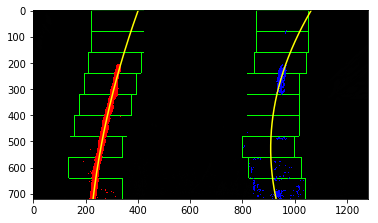

In [15]:
out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)